# ECON 31740 Final Project
## Gursahib Suri

In [563]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import yfinance as yf
import matplotlib.pyplot as plt
import pandas_datareader.data as web

from sklearn.linear_model import Lasso, Ridge, LassoCV,LassoLarsIC
from sklearn.metrics import mean_squared_error

import warnings
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning



plt.style.use('ggplot')

In [183]:
START_DATE = "2019-01-02"
END_DATE = "2021-01-02"

## US Equity Returns

In [564]:
path = 'tickers.csv'
tickers = pd.read_csv(path)
tickers =list(tickers.Symbol)


In [565]:
len(tickers)

100

In [185]:

emp =[]
for tick in tickers:
    
    tab = yf.download(tick, start=START_DATE, end=END_DATE,progress=False)['Adj Close']
    
    tab = tab.to_frame(tick)
    emp.append(tab)
    
stockreturns = pd.concat(emp,axis=1).pct_change()


In [187]:
stockreturns=stockreturns[1:].dropna(axis=1)
stockreturns.head()

,AAPL,MSFT,GOOG,AMZN,TSLA,BRK-A,NVDA,FB,UNH,JNJ,...,CME,MU,ADI,MMM,MDLZ,USB,PNC,DUK,SQ,MMC
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-03,-0.099607,-0.036788,-0.028484,-0.025242,-0.031472,-0.056098,-0.060417,-0.029039,-0.027270,-0.015890,...,-0.021985,-0.053435,-0.060405,-0.037654,-0.003760,-0.014024,-0.004545,-0.000354,-0.083566,-0.013031
2019-01-04,0.042689,0.046509,0.053786,0.050064,0.057697,0.019164,0.064067,0.047138,0.011695,0.016783,...,0.017521,0.054839,0.024278,0.041141,0.027680,0.024727,0.025028,0.008268,0.109882,0.024484
2019-01-07,-0.002226,0.001275,-0.002167,0.034353,0.054361,0.009915,0.052941,0.000725,0.001920,-0.006415,...,-0.005036,0.039755,0.006289,-0.002300,0.006856,-0.004698,-0.002227,-0.004217,0.043658,0.004379
2019-01-08,0.019063,0.007251,0.007385,0.016612,0.001164,-0.003724,-0.024895,0.032452,0.013371,0.023227,...,-0.005932,-0.007647,0.024396,0.004191,0.023346,0.006436,0.001571,0.012587,0.039526,0.006852
2019-01-09,0.016982,0.014300,-0.001505,0.001714,0.009483,0.000883,0.019667,0.011927,0.001439,-0.007926,...,-0.022446,0.050385,0.025340,0.003235,-0.003565,0.010659,-0.002806,-0.014754,0.044518,0.000866


In [188]:
spy = yf.download("SPY", start=START_DATE, end=END_DATE,progress=False)['Adj Close']

## SPY Returns

In [192]:
spy_returns = spy.dropna(axis=0)
spy_returns = spy_returns.pct_change()
spy_returns = spy_returns.to_frame('Return').dropna()
spy_returns.head()

,Return
Date,
2019-01-03,-0.023863
2019-01-04,0.033496
2019-01-07,0.007885
2019-01-08,0.009395
2019-01-09,0.004674


In [566]:
df=pd.concat([stockreturns,spy_returns],axis=1).dropna()


## Building $\lambda_t$ Time-Series

In [456]:
@ignore_warnings(category=ConvergenceWarning)
def get_param(df, window_len,method):
    
    numb_obs = len(df)-window_len
    N=window_len
    
    lambs=pd.DataFrame(index=df.index[window_len:],columns=['Lambda'])
    
    if method == 'CV':
        regtest = LassoCV(cv=3)
    elif method =='AIC':
        regtest = LassoLarsIC(criterion='aic', normalize=False)
    elif method =='BIC':
        regtest = LassoLarsIC(criterion='bic', normalize=False)
        
  
    for i in range(0,numb_obs):
    
        date = df.index[i+N]
        
        reg = regtest.fit(df.drop(columns='Return').iloc[i:i+N],df['Return'].iloc[i:i+N])
        K = regtest.alpha_

        
        lambs.loc[date] = K
    res = (lambs - np.min(lambs)) / (np.max(lambs) - np.min(lambs))     
    return lambs

In [567]:
warnings.filterwarnings("ignore", category=DeprecationWarning) 

results = get_param(df, 30,'CV')
results2 = get_param(df, 30,'AIC')
results3 = get_param(df, 30,'BIC')

### CV

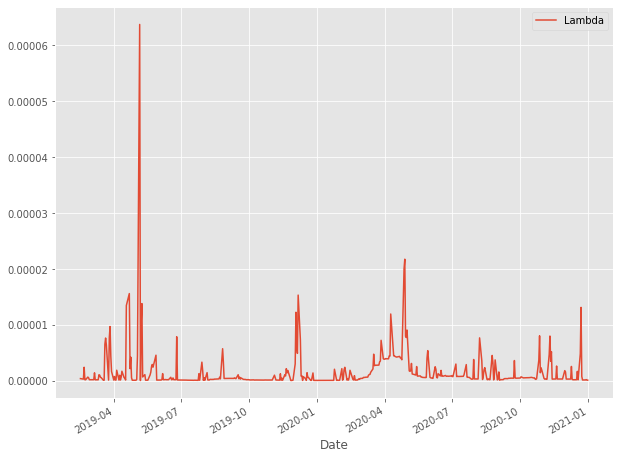

In [568]:
results.plot()

## AIC

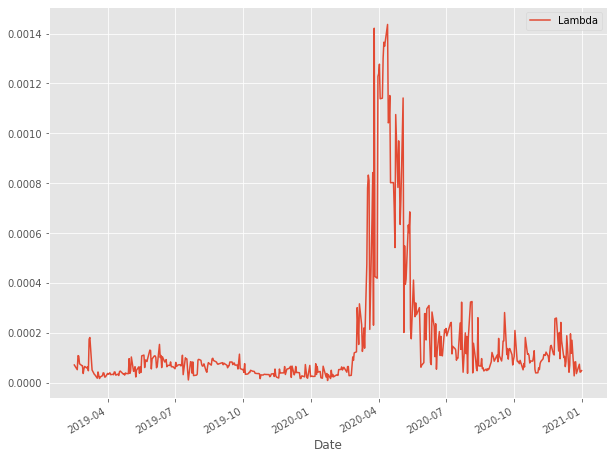

In [569]:
results2.plot()

## BIC

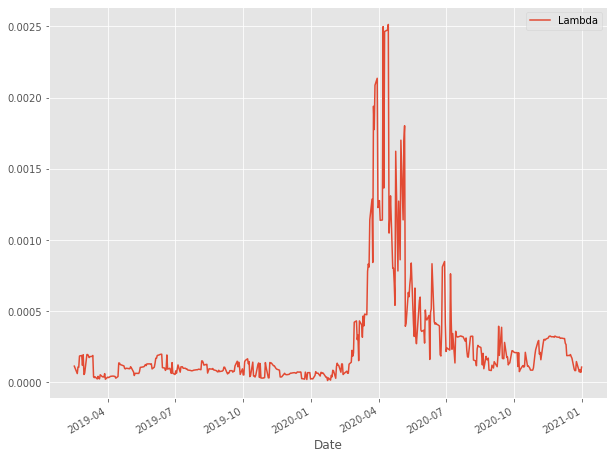

In [570]:
results3.plot()

In [658]:
def summary_stats(df):
    report = pd.DataFrame()
    report['Mean'] = df.mean() 
    report['Vol'] = df.std() 
    report['Max'] = df.max()
    return round(report, 6)

In [663]:
print(summary_stats(pd.concat([results.rename(columns={'Lambda':'CV'}),\
results2.rename(columns={'Lambda':'AIC'}),results3.rename(columns={'Lambda':'BIC'})],axis=1)).to_latex())

\begin{tabular}{lrrl}
\toprule
{} &      Mean &       Vol &       Max \\
\midrule
CV  &  0.000002 &  0.000004 &  0.000064 \\
AIC &  0.000155 &  0.000245 &  0.001437 \\
BIC &  0.000260 &  0.000380 &  0.002514 \\
\bottomrule
\end{tabular}



In [674]:
print(pd.concat([results.rename(columns={'Lambda':'CV'}),results2.rename(columns={'Lambda':'AIC'})\
           ,results3.rename(columns={'Lambda':'BIC'})],axis=1).astype(float).corr().to_latex())

\begin{tabular}{lrrr}
\toprule
{} &        CV &       AIC &       BIC \\
\midrule
CV  &  1.000000 &  0.232292 &  0.215586 \\
AIC &  0.232292 &  1.000000 &  0.830977 \\
BIC &  0.215586 &  0.830977 &  1.000000 \\
\bottomrule
\end{tabular}



## Comparing with VIX - Volatility measure in US Markets

In [367]:
vix = yf.download('^VIX', start=START_DATE, end=END_DATE,progress=False)['Adj Close'].to_frame('VIX')

In [687]:
print(pd.concat([results.rename(columns={'Lambda':'CV'}),results2.rename(columns={'Lambda':'AIC'}),results3.rename(columns={'Lambda':'BIC'}),vix],axis=1).dropna().astype(float).corr().to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &        CV &       AIC &       BIC &       VIX \\
\midrule
CV  &  1.000000 &  0.232292 &  0.215586 &  0.131668 \\
AIC &  0.232292 &  1.000000 &  0.830977 &  0.652283 \\
BIC &  0.215586 &  0.830977 &  1.000000 &  0.682984 \\
VIX &  0.131668 &  0.652283 &  0.682984 &  1.000000 \\
\bottomrule
\end{tabular}



## CV

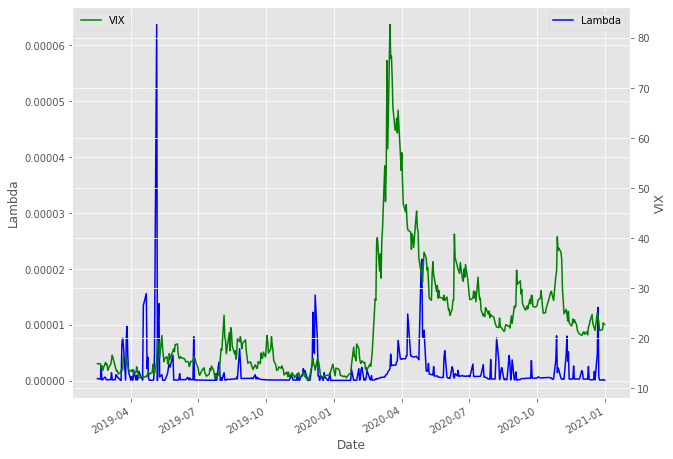

In [577]:
plt.rcParams["figure.figsize"] = (10,8)
fig, ax1 = plt.subplots(1,1)
results.plot(ax=ax1, color='blue', label='a')
ax2 = ax1.twinx()
vix[results.index[0]:].plot(ax=ax2, color='green', label='b')
ax1.set_ylabel('Lambda')
ax2.set_ylabel('VIX')
ax1.legend(loc=1)
ax2.legend(loc=2)

plt.show()

## AIC

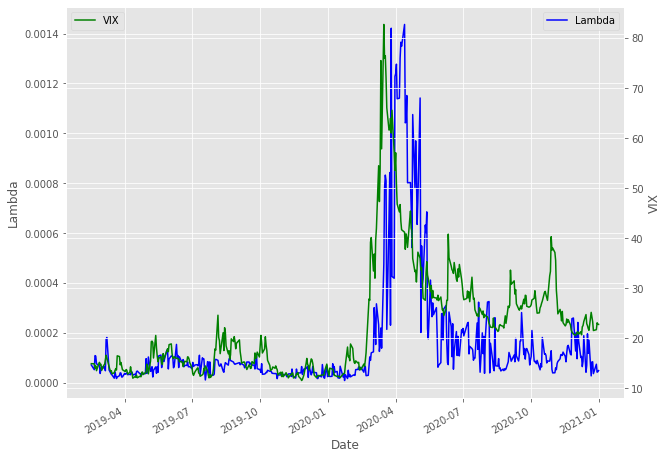

In [575]:
plt.rcParams["figure.figsize"] = (10,8)
fig, ax1 = plt.subplots(1,1)
results2.plot(ax=ax1, color='blue', label='a')
ax2 = ax1.twinx()
vix[results2.index[0]:].plot(ax=ax2, color='green', label='b')
ax1.set_ylabel('Lambda')
ax2.set_ylabel('VIX')
ax1.legend(loc=1)
ax2.legend(loc=2)

plt.show()

## AIC vs BIC

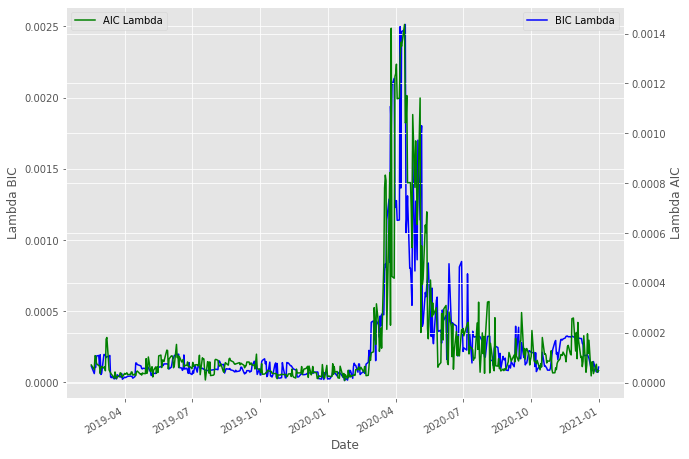

In [584]:
plt.rcParams["figure.figsize"] = (10,8)
fig, ax1 = plt.subplots(1,1)
results3.rename(columns={'Lambda':'BIC Lambda'}).plot(ax=ax1, color='blue', label='a')
ax2 = ax1.twinx()
results2.rename(columns={'Lambda':'AIC Lambda'}).plot(ax=ax2, color='green', label='b')
ax1.set_ylabel('Lambda BIC')
ax2.set_ylabel('Lambda AIC')
ax1.legend(loc=1)
ax2.legend(loc=2)

plt.show()

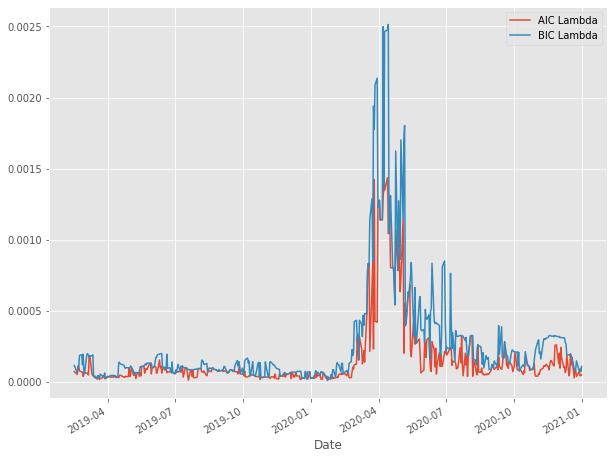

In [586]:
pd.concat([results2.rename(columns={'Lambda':'AIC Lambda'}),results3.rename(columns={'Lambda':'BIC Lambda'})],axis=1).plot()

## AIC vs Market

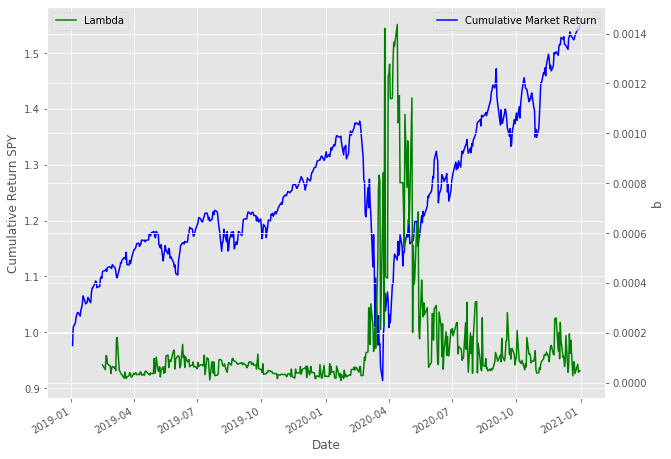

In [587]:
plt.rcParams["figure.figsize"] = (10,8)
fig, ax1 = plt.subplots(1,1)
(spy_returns+1).cumprod().rename(columns={'Return':'Cumulative Market Return'}).plot(ax=ax1, color='blue', label='a')
ax2 = ax1.twinx()
results2.plot(ax=ax2, color='green', label='b')
ax1.set_ylabel('Cumulative Return SPY')
ax2.set_ylabel('b')
ax1.legend(loc=1)
ax2.legend(loc=2)

plt.show()

## India Equity Returns

In [435]:
path2 = 'NSE-tickers.xlsx'
tickers2 = pd.read_excel(path2)
tickers2 = tickers2.Symbol.to_frame('Ticker').iloc[0:100]


In [440]:

emp2 =[]
for tick in list(tickers2.Ticker):
    
    tab = yf.download(tick+'.NS', start=START_DATE, end=END_DATE,progress=False)['Adj Close']
    
    tab = tab.to_frame(tick)
    emp2.append(tab)
    
stockreturns_NSE = pd.concat(emp2,axis=1).pct_change()



1 Failed download:
- ZOMATO.NS: Data doesn't exist for startDate = 1546408800, endDate = 1609567200

1 Failed download:
- NYKAA.NS: Data doesn't exist for startDate = 1546408800, endDate = 1609567200

1 Failed download:
- PAYTM.NS: Data doesn't exist for startDate = 1546408800, endDate = 1609567200

1 Failed download:
- LODHA.NS: Data doesn't exist for startDate = 1546408800, endDate = 1609567200


In [442]:
stockreturns_NSE=stockreturns_NSE[1:].dropna(axis=1)
stockreturns_NSE.head()

,RELIANCE,TCS,HDFCBANK,INFY,HINDUNILVR,ICICIBANK,HDFC,BAJFINANCE,SBIN,WIPRO,...,HDFCAMC,GODREJPROP,BEL,BOSCHLTD,PGHH,IDBI,CADILAHC,JSWENERGY,HEROMOTOCO,JUBLFOOD
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-03,-0.012337,-0.012141,-0.007846,0.000149,0.002129,-0.003703,-0.022114,-0.010654,-0.009527,-0.000154,...,0.008532,0.010824,-0.010033,-0.009136,-0.004548,0.000000,-0.008940,-0.009936,-0.010471,0.000404
2019-01-04,0.005399,-0.012158,0.002676,-0.012105,-0.003746,0.005368,0.018458,-0.003925,0.022501,-0.003226,...,0.002930,0.003323,0.034347,0.007197,-0.006604,0.001630,0.001600,-0.015054,-0.008890,-0.022224
2019-01-07,0.005552,0.011215,0.001511,0.016111,0.001824,0.006846,0.000152,-0.008715,-0.004536,-0.000616,...,-0.010503,0.048506,-0.004899,0.003686,0.001967,-0.002441,0.013655,0.020379,-0.010007,0.004084
2019-01-08,-0.000091,-0.002292,-0.008323,-0.002457,-0.007899,0.033859,-0.007071,-0.006481,0.030375,0.004009,...,-0.010946,0.027799,-0.006017,-0.010753,0.017773,0.009788,0.001003,0.002853,0.004175,0.019063
2019-01-09,0.005522,-0.003486,0.006562,0.009029,0.007991,0.005524,0.018377,-0.005006,0.000000,0.010597,...,0.006406,0.013729,0.016511,0.009106,0.000401,0.044426,-0.004438,-0.006401,-0.011059,-0.004918


In [452]:
nifty = yf.download("^NSEI", start=START_DATE, end=END_DATE,progress=False)['Adj Close']

## NIFTY Benchmark Returns

In [453]:
n_ret = nifty.dropna(axis=0)
n_ret = n_ret.pct_change()
n_ret = n_ret.to_frame('Return').dropna()
n_ret.head()

,Return
Date,
2019-01-03,-0.011142
2019-01-04,0.005163
2019-01-07,0.004144
2019-01-08,0.002818
2019-01-09,0.004906


In [588]:
df_NSE=pd.concat([stockreturns_NSE,n_ret],axis=1).dropna()


In [457]:
warnings.filterwarnings("ignore", category=DeprecationWarning) 

results_NSE_CV = get_param(df_NSE, 30,'CV')

In [599]:
warnings.filterwarnings("ignore", category=DeprecationWarning) 

results_NSE_AIC = get_param(df_NSE, 30,'AIC')

In [459]:
warnings.filterwarnings("ignore", category=DeprecationWarning) 

results_NSE_BIC = get_param(df_NSE, 30,'BIC')

## CV

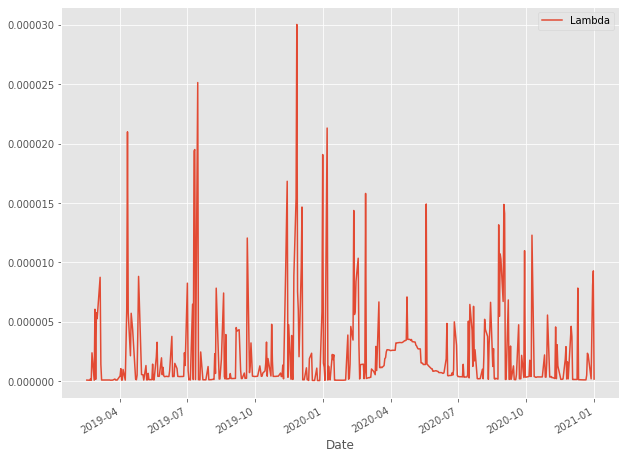

In [600]:
results_NSE_CV.plot()

## AIC

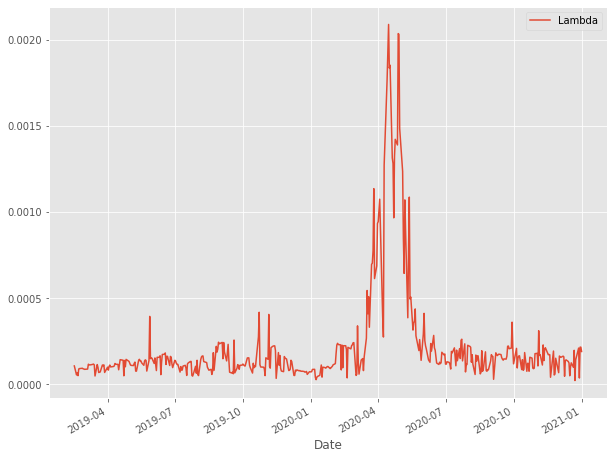

In [601]:
results_NSE_AIC.plot()

##  BIC

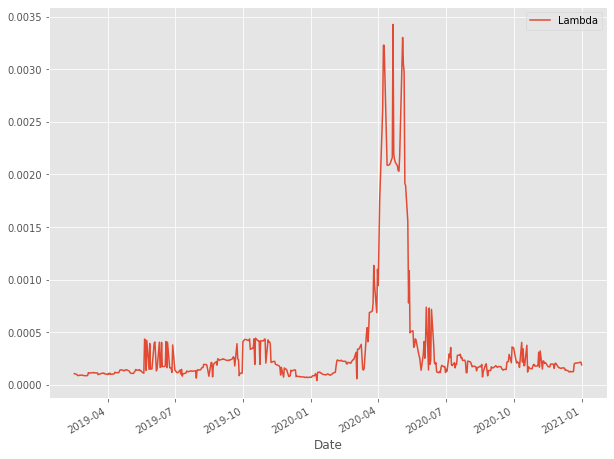

In [602]:
results_NSE_BIC.plot()

In [468]:
nse_path = 'vix_ind_1.csv'
nse_path2 = 'vix_ind_2.csv'
vix_1_ind = pd.read_csv(nse_path)
vix_2_ind = pd.read_csv(nse_path2)

In [514]:
#vix_1_ind=vix_1_ind.set_index('Date ')
#vix_2_ind=vix_2_ind.set_index('Date ')
vix_1_ind = vix_1_ind['Close '].to_frame('INDIA VIX')
vix_2_ind = vix_2_ind['Close '].to_frame('INDIA VIX')
vix_NSE= pd.concat([vix_1_ind,vix_2_ind])
vix_NSE.index = pd.to_datetime(vix_NSE.index)

In [686]:
print(summary_stats(pd.concat([results_NSE_CV.rename(columns={'Lambda':'CV'}),results_NSE_BIC.rename(columns={'Lambda':'BIC'}),results_NSE_AIC.rename(columns={'Lambda':'AIC'})],axis=1)).to_latex())

\begin{tabular}{lrrl}
\toprule
{} &      Mean &       Vol &       Max \\
\midrule
CV  &  0.000002 &  0.000004 &   0.00003 \\
BIC &  0.000320 &  0.000506 &  0.003426 \\
AIC &  0.000211 &  0.000296 &  0.002089 \\
\bottomrule
\end{tabular}



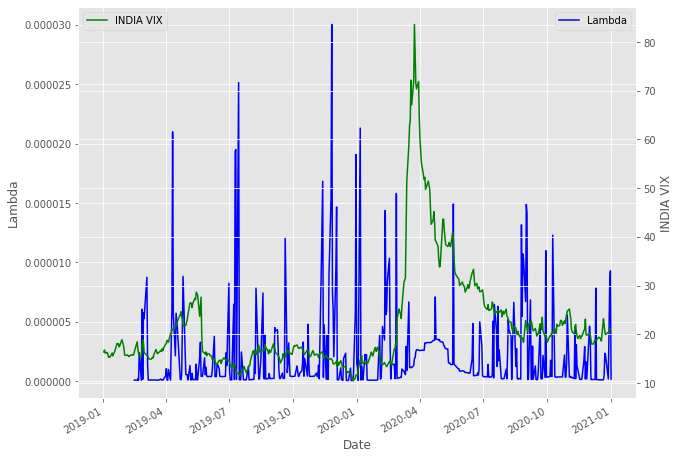

In [589]:
plt.rcParams["figure.figsize"] = (10,8)
fig, ax1 = plt.subplots(1,1)
results_NSE_CV.plot(ax=ax1, color='blue', label='a')
ax2 = ax1.twinx()
vix_NSE.plot(ax=ax2, color='green', label='b')
ax1.set_ylabel('Lambda')
ax2.set_ylabel('INDIA VIX')
ax1.legend(loc=1)
ax2.legend(loc=2)

plt.show()

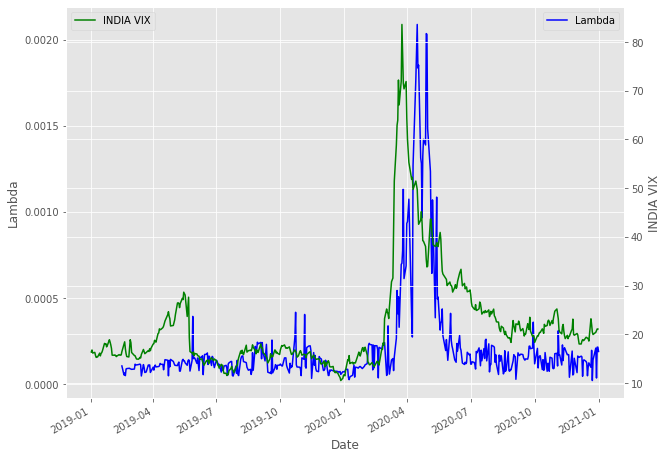

In [603]:
plt.rcParams["figure.figsize"] = (10,8)
fig, ax1 = plt.subplots(1,1)
results_NSE_AIC.plot(ax=ax1, color='blue', label='a')
ax2 = ax1.twinx()
vix_NSE.plot(ax=ax2, color='green', label='b')
ax1.set_ylabel('Lambda')
ax2.set_ylabel('INDIA VIX')
ax1.legend(loc=1)
ax2.legend(loc=2)

plt.show()

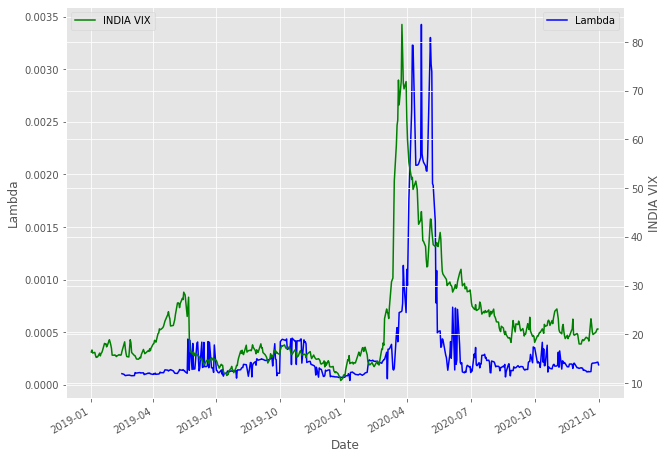

In [604]:
plt.rcParams["figure.figsize"] = (10,8)
fig, ax1 = plt.subplots(1,1)
results_NSE_BIC.plot(ax=ax1, color='blue', label='a')
ax2 = ax1.twinx()
vix_NSE.plot(ax=ax2, color='green', label='b')
ax1.set_ylabel('Lambda')
ax2.set_ylabel('INDIA VIX')
ax1.legend(loc=1)
ax2.legend(loc=2)

plt.show()

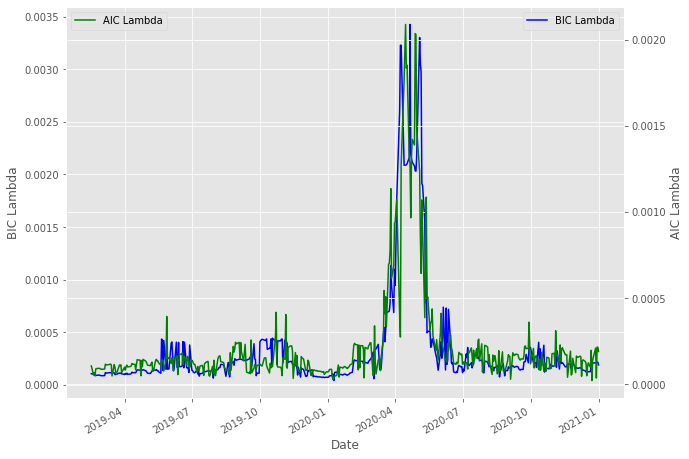

In [607]:
plt.rcParams["figure.figsize"] = (10,8)
fig, ax1 = plt.subplots(1,1)
results_NSE_BIC.rename(columns={'Lambda':'BIC Lambda'}).plot(ax=ax1, color='blue', label='a')
ax2 = ax1.twinx()
results_NSE_AIC.rename(columns={'Lambda':'AIC Lambda'}).plot(ax=ax2, color='green', label='b')
ax1.set_ylabel('BIC Lambda')
ax2.set_ylabel('AIC Lambda')
ax1.legend(loc=1)
ax2.legend(loc=2)

plt.show()

In [689]:
print(pd.concat([results_NSE_BIC.rename(columns={'Lambda':'INDIA BIC'}),results3.rename(columns={'Lambda':'USA BIC'})],axis=1).astype(float).corr().to_latex())

\begin{tabular}{lrr}
\toprule
{} &  INDIA BIC &   USA BIC \\
\midrule
INDIA BIC &   1.000000 &  0.744119 \\
USA BIC   &   0.744119 &  1.000000 \\
\bottomrule
\end{tabular}



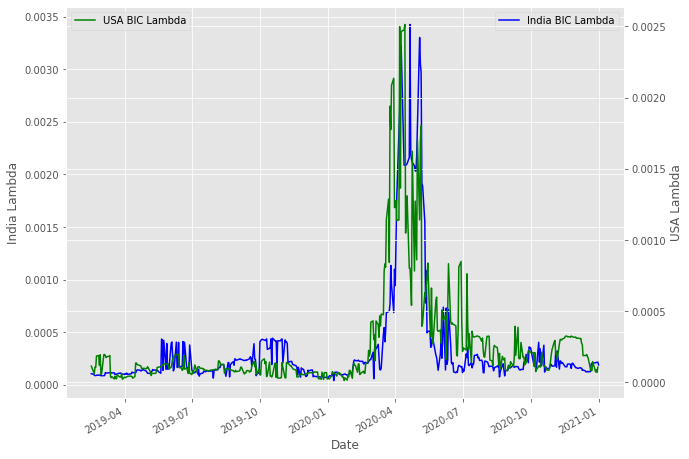

In [609]:
plt.rcParams["figure.figsize"] = (10,8)
fig, ax1 = plt.subplots(1,1)
results_NSE_BIC.rename(columns={'Lambda':'India BIC Lambda'}).plot(ax=ax1, color='blue', label='a')
ax2 = ax1.twinx()
results3.rename(columns={'Lambda':'USA BIC Lambda'}).plot(ax=ax2, color='green', label='b')
ax1.set_ylabel('India Lambda')
ax2.set_ylabel('USA Lambda')
ax1.legend(loc=1)
ax2.legend(loc=2)

plt.show()

In [613]:
warnings.filterwarnings("ignore", category=DeprecationWarning) 

results_NSE_BIC_10 = get_param(df_NSE, 10,'BIC')


results_NSE_BIC_90 = get_param(df_NSE, 90,'BIC')

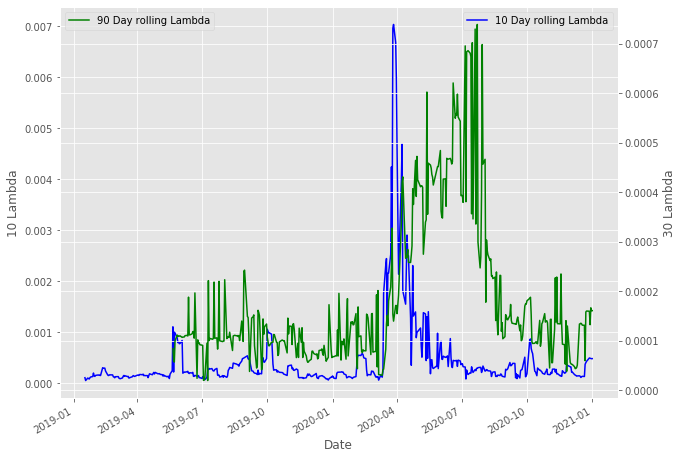

In [614]:
plt.rcParams["figure.figsize"] = (10,8)
fig, ax1 = plt.subplots(1,1)
results_NSE_BIC_10.rename(columns={'Lambda':'10 Day rolling Lambda'}).plot(ax=ax1, color='blue', label='a')
ax2 = ax1.twinx()
results_NSE_BIC_90.rename(columns={'Lambda':'90 Day rolling Lambda'}).plot(ax=ax2, color='green', label='b')
ax1.set_ylabel('10 Lambda')
ax2.set_ylabel('30 Lambda')
ax1.legend(loc=1)
ax2.legend(loc=2)

plt.show()

## Prediction Error

In [553]:
@ignore_warnings(category=ConvergenceWarning)
def prediction_error(df, window_len,method):
    
    
    numb_obs = len(df)-window_len
    N=window_len
    
    lambs=pd.DataFrame(index=df.index[window_len:],columns=['Lambda'])
    
    if method == 'CV':
        regtest = LassoCV(cv=3)
    elif method =='AIC':
        regtest = LassoLarsIC(criterion='aic', normalize=False)
    elif method =='BIC':
        regtest = LassoLarsIC(criterion='bic', normalize=False)
        
    error = []
    for i in range(0,numb_obs):
    
        date = df.index[i+N]
        
        reg = regtest.fit(df.drop(columns='Return').iloc[i:i+N],df['Return'].iloc[i:i+N])
        
        y_pred = regtest.predict(df.iloc[i+N:i+N+1].drop(columns='Return'))
        
        y_real = df.iloc[i+N:i+N+1]['Return']
        
        sq_error= (y_real[0]-y_pred[0])**2
        error.append(sq_error)

        
        lambs.loc[date] = K

    MSE = sum(error)/len(error)
    
    return MSE

In [560]:
e1=prediction_error(df, 30,'CV')
e2=prediction_error(df, 30,'AIC')
e3=prediction_error(df, 30,'BIC')

In [593]:
e10=prediction_error(df_NSE, 30,'CV')
e20=prediction_error(df_NSE, 30,'AIC')
e30=prediction_error(df_NSE, 30,'BIC')

In [627]:
print((pd.DataFrame(np.array([[e1, e2, e3], [e10, e20, e30]]), columns=['CV', 'AIC', 'BIC'],index=['US Data','INDIA Data'])*100000).to_latex())

\begin{tabular}{lrrr}
\toprule
{} &        CV &        AIC &        BIC \\
\midrule
US Data    &  1.423758 &   8.713874 &  13.037315 \\
INDIA Data &  1.568131 &  13.796237 &  19.006013 \\
\bottomrule
\end{tabular}

